# Procesamiento de datos
## Importar datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import numpy as np
import scipy.signal as signal

In [ ]:
%cd /content/drive/MyDrive/5TOCICLO/Patrones # modificar esto con el path del drive donde suba el archivo adjunto de EDA.zip

/content/drive/MyDrive/5TOCICLO/Patrones


In [ ]:
!unzip "EDA.zip"

In [ ]:
# Seleccionamos estilo de ploteo
plt.style.use("ggplot")

In [ ]:
pathName="EDA/S01F1EDA.csv"
eda_rawNoLimit= np.genfromtxt(pathName, delimiter="\n")
eda_rawNoLimit #Revisamos el array

array([1.54402734e+09, 4.00000000e+00, 0.00000000e+00, ...,
       2.69080000e-02, 2.56270000e-02, 2.69080000e-02])

## Delimitamos el tiempo de la prueba

In [ ]:
# Esta delimitación solo sirvió para armar el algoritmo de procesamiento.
# Posteriormente, los limites son definidios de otro modo.

Fs=4 #Frecuencia de muestreo del dispositivo de adquisición

#Eliminamos el primer valor para mantener una escala adecuada
indStart=int(eda_rawNoLimit[0]/1e+5) # El primer término de la data
eda_raw=eda_rawNoLimit[indStart:,] # Establecimiento del inicio de la prueba
print(indStart)

indEnd=np.where(eda_rawNoLimit< 0.1) # Encontramos aquellos indices cuyas amplutudes sean valores menores a 0.1
#print(indEnd)
last=np.where(indEnd[0]> 49000)[0][0] # Deimitamos los índices
#print(last)

eda_raw=eda_raw[0:indEnd[0][last]-indStart] # Establecimiento del final de la prueba"""
eda_raw

15440


array([0.179386, 0.180668, 0.179386, ..., 0.207576, 0.224233, 0.201169])

## Graficar los datos

In [ ]:
Ts=1/Fs
n = np.arange(0,eda_raw.shape[0])  # t = n*Ts
t = n*Ts

"""#Ploteamos la señal en el tiempo
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, eda_raw)"""

'#Ploteamos la señal en el tiempo\nplt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica\nplt.plot(t, eda_raw)'

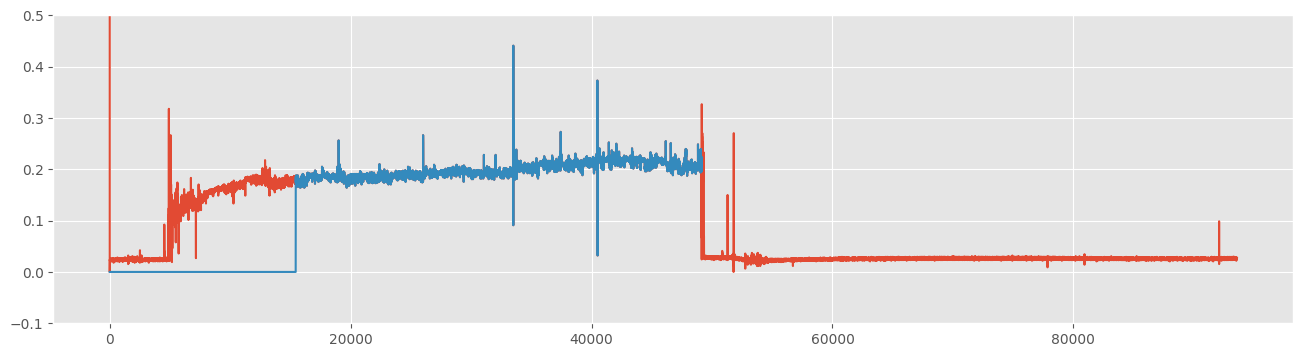

In [ ]:
padZeros=np.zeros(indStart,dtype=float)

fig, ax = plt.subplots(figsize=(16, 4))
plt.plot(eda_rawNoLimit)
plt.plot(np.concatenate((padZeros, eda_raw), axis=None))
#plt.xlim(0,20000)
plt.ylim(-0.1,0.5)
plt.show()

Text(0.5, 0, 'tiempo (s)')

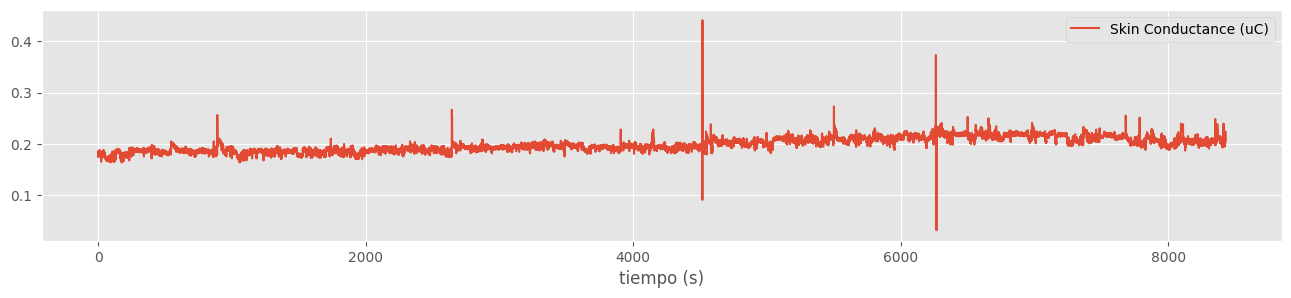

In [ ]:
#Pasamos el formato a un dataFrame de Panda
sensor = np.concatenate((t.reshape(-1,1),  eda_raw.reshape(-1,1)), axis=1)

#Creamos el data frame con las varibles t y d_sensor
df = pd.DataFrame(sensor, columns=["t","Skin Conductance (uC)"])

#Establecemos t como index Para no estar encontrando los indices
df = df.set_index("t")
df.head()

#Ploteamos la señal
df.plot(figsize=(16,3))
plt.xlabel("tiempo (s)")
#plt.xlim(0,1)
#####plt.plot(df.index, df.loc[936])#######

## Filtrar la señal con un pasabaja con una frecuencia de corte de 0.002 Hz

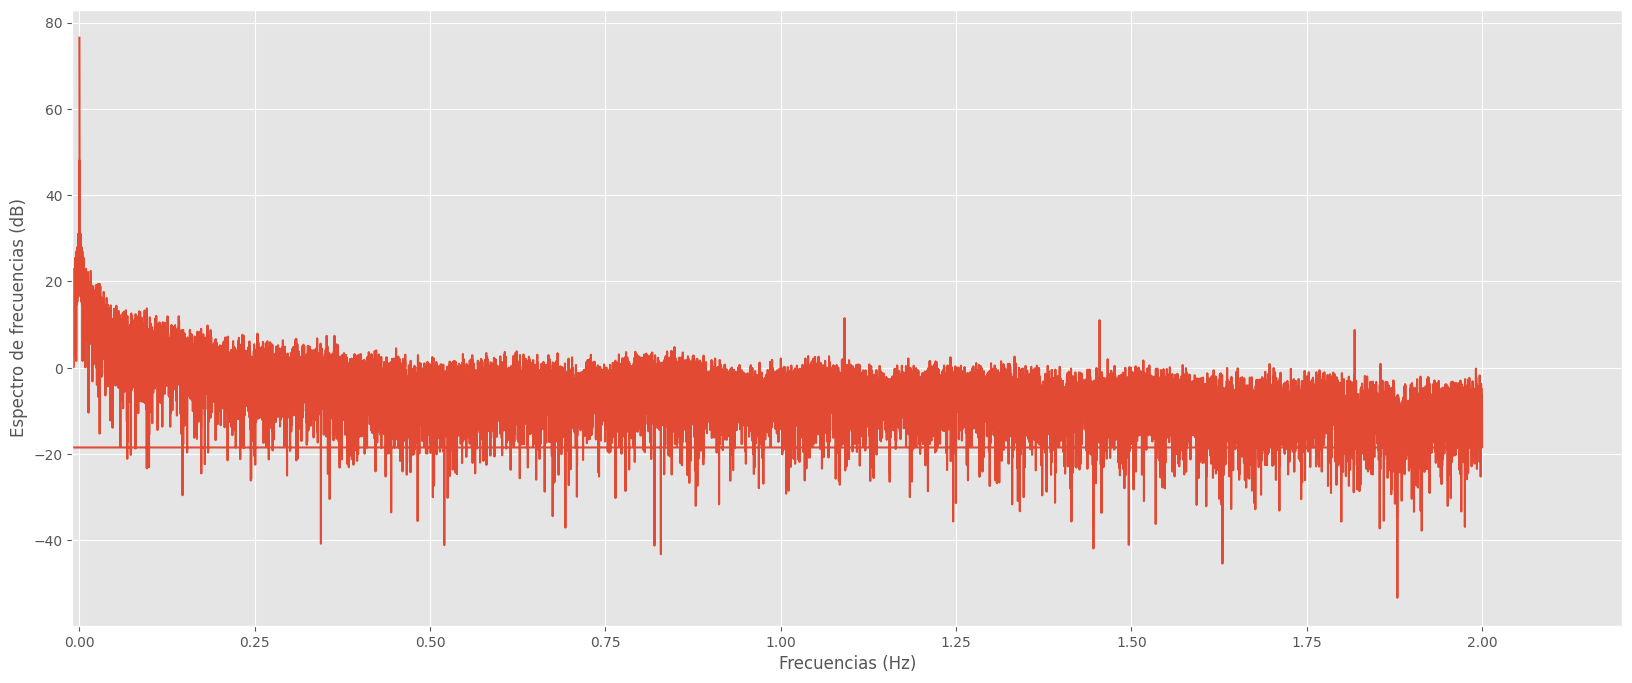

In [ ]:
# Graficamos la FFT de la señal EDA
fft = np.fft.fft(eda_raw)
freqs = np.fft.fftfreq(len(eda_raw), 1/Fs)

# Ploteamos

plt.figure(figsize=(20,8))
plt.plot(freqs, 20*np.log10(np.abs(fft)))
plt.xlabel('Frecuencias (Hz)')
plt.xlim([-0.01,2.2])
plt.ylabel('Espectro de frecuencias (dB)')
plt.show()

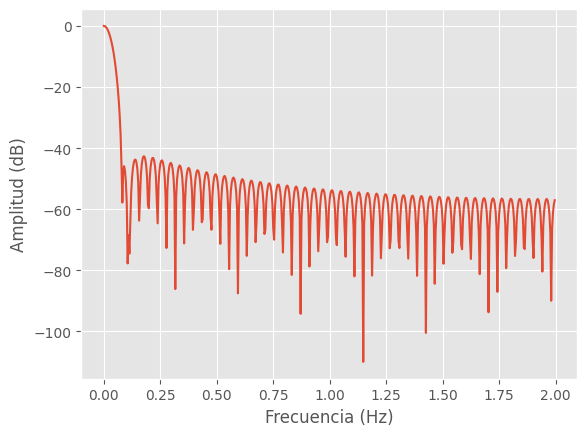

array([0.00026445, 0.00053383, 0.00081039, ..., 0.20774606, 0.20775053,
       0.20771257])

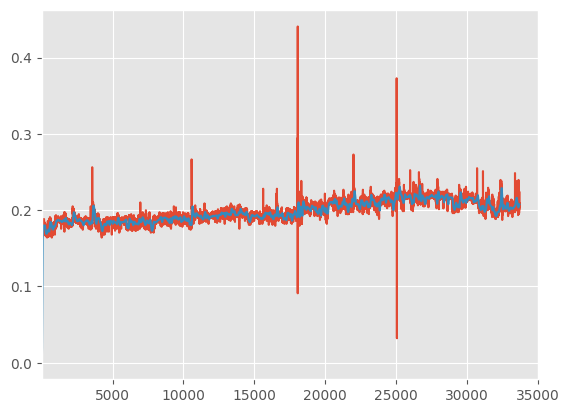

In [ ]:
# Se definen los parámetros del filtro
fc = 0.002  # Hz
M = 101
FIRfilter = signal.firwin(M, fc, window='hamming',fs=Fs)

w, h = signal.freqz(FIRfilter, 1)
freq = w / (2 * np.pi) * Fs
amp = 20 * np.log10(np.abs(h))

#Pleateamos
plt.plot(freq, amp)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.show()

# Aplicamos el filtro a la señal 
eda_filt = signal.lfilter(FIRfilter, 1, eda_raw)

# Ploteamos
plt.plot(eda_raw)
plt.plot(eda_filt)
plt.xlim(1,35000)

eda_filt

 ## Enventanamiento


Text(0, 0.5, 'Conductancia (uC)')

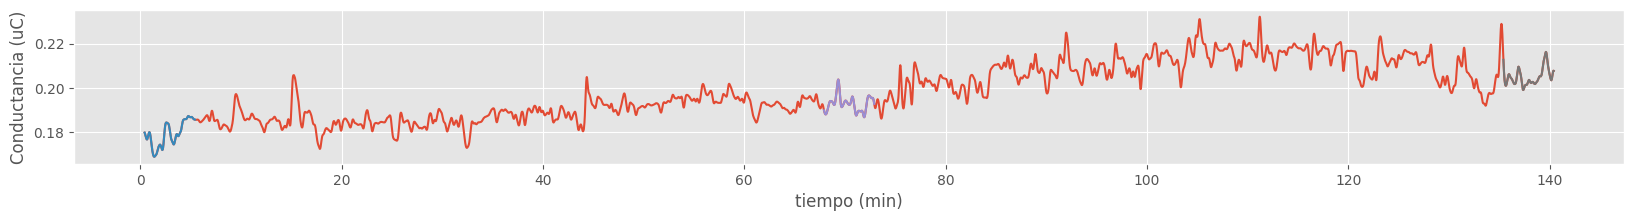

In [ ]:
Tw5=5*60*Fs
Tw15=15*60*Fs
Tw30=30*60*Fs

Tw=Tw5
"""ventana5=np.zeros(eda_filt.size)
ventana5[0:Tw]=1 #Ventana inicial
ventana5[int((eda_filt.size/2)-(Tw/2)):int((eda_filt.size/2)+(Tw/2)-1)]=1 # Ventana media
ventana5[-Tw:,]=1 # Ventana final

ventana5=ventana5.astype(dtype=bool)
plt.plot(t, ventana5)"""
#Enventanamos la señal ya filtrada
correc=25*Fs #se van a eliminar algunos samples para no alterar el cálculo de la media ni de la varianza
eda_filt=eda_filt[correc:,]
eda_raw=eda_raw[correc:,]
t=t[correc:,]

eda_St= eda_filt[0:Tw] #Ventana inicial
eda_Md= eda_filt[int((eda_filt.size/2)-(Tw/2)):int((eda_filt.size/2)+(Tw/2)-1)] #Ventana media
eda_Ed= eda_filt[-Tw:,] #Ventana final

#Guardamos sus respectivos tiempos
t_St= t[0:Tw] #Ventana inicial
t_Md= t[int((eda_filt.size/2)-(Tw/2)):int((eda_filt.size/2)+(Tw/2)-1)] #Ventana media
t_Ed= t[-Tw:,] #Ventana final

plt.figure(figsize=(20,2))
plt.plot(t/60, eda_filt)
plt.plot((t_St)/60, eda_St)
plt.plot(t_Md/60, eda_Md)
plt.plot(t_Ed/60, eda_Ed)
plt.xlabel("tiempo (min)")
plt.ylabel("Conductancia (uC)")

## Cálculo de las características

In [ ]:
"""edaDiff_St=eda_St[1:,]-eda_St[0:-1]
edaDiff_Md=np.diff(eda_Md)
edaDiff_Ed=np.diff(eda_Ed)"""

'edaDiff_St=eda_St[1:,]-eda_St[0:-1]\nedaDiff_Md=np.diff(eda_Md)\nedaDiff_Ed=np.diff(eda_Ed)'

Text(0, 0.5, 'Derivada de\n Conductancia (uC)')

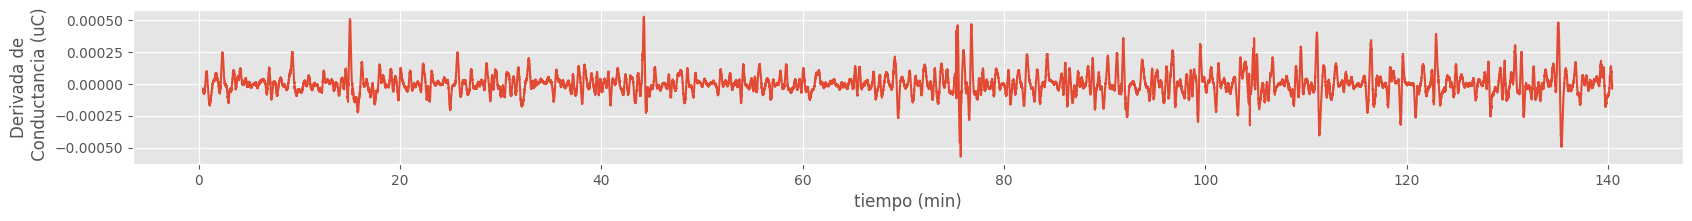

In [ ]:
# Hallamos la derivada de la señal EDA
eda_Diff=np.diff(eda_filt)

plt.figure(figsize=(20,2))
plt.plot(t[1:,]/60, eda_Diff)
plt.xlabel("tiempo (min)")
plt.ylabel("Derivada de\n Conductancia (uC)")

In [ ]:
# Hallamos las medias
u_St=np.mean(eda_St, axis=0)
u_Md=np.mean(eda_Md, axis=0)
u_Ed=np.mean(eda_Ed, axis=0)
u_Diff=np.mean(eda_Diff, axis=0)

print("mean Start \t\t= ", u_St, "\nmean Middle \t\t= ", u_Md,"\nmean End \t\t= ", u_Ed,"\nmean Derivative \t= ", u_Diff)

mean Start 		=  0.17919418443729715 
mean Middle 		=  0.19287906028205068 
mean End 		=  0.20495101648872932 
mean Derivative 	=  8.304221462991514e-07


In [ ]:
# Hallamos las varianzas
var_St=np.var(eda_St)
var_Md=np.var(eda_Md)
var_Ed=np.var(eda_Ed)
var_Diff=np.var(eda_Diff)

print("Variance Start \t\t= ", var_St, "\nVariance Middle \t= ", var_Md,"\nVariance End \t\t= ", var_Ed,"\nVariance Derivative \t= ", var_Diff)

Variance Start 		=  3.069119373480641e-05 
Variance Middle 	=  1.2882627200277469e-05 
Variance End 		=  1.4421754525405561e-05 
Variance Derivative 	=  8.110767904632927e-09


In [ ]:
# Hallamos la proporción
rho=u_Md/(u_St+u_Ed)
print("Ratio \t\t\t= ", rho)

Ratio 			=  0.5020993619524424


# Formamos los dataframes. 
Habrán 3, cada uno corresponde a la duración del Tw de los enventanados.







In [ ]:
column_names=["Student", "Exam", "mu_Start", "mu_Middle", "mu_End","var_Start", "var_Middle", "var_End", "ratio", "mu_diff","var_diff", "More80"]
Tw5_data=pd.DataFrame(columns=column_names)
Tw15_data=pd.DataFrame(columns=column_names)
Tw30_data=pd.DataFrame(columns=column_names)

### Función general

In [ ]:
# Creamos una función que comprenda todo el proceso anterior para la extracción de las características

def features_EDA(eda_raw, fc, Fs,t):

  #-----------------------------FILTRAMOS LA SEÑAL-----------------------------
  # Se definen los parámetros del filtro
  M = 101
  FIRfilter = signal.firwin(M, fc, window='hamming',fs=Fs)

  # Aplicamos el filtro a la señal 
  eda_filt = signal.lfilter(FIRfilter, 1, eda_raw)

  correc=25*Fs #se van a eliminar algunos samples para no alterar el cálculo de la media ni de la varianza
  eda_filt=eda_filt[correc:,]
  eda_raw=eda_raw[correc:,]
  t=t[correc:,]

  #-----------------------------DERIVAMOS LA SEÑAL Y CALCULAMOS SUS FEATURES-----------------------------
  # Hallamos la derivada de la señal EDA
  eda_Diff=np.diff(eda_filt)
  u_Diff=np.mean(eda_Diff, axis=0)
  var_Diff=np.var(eda_Diff)

  #-----------------------------GENERAMOS EL ENVENTANADO y CALCULAMOS LOS FEATURES POR CADA VENTANA -----------------------------

  Tw5=5*60*Fs
  Tw15=15*60*Fs
  Tw30=30*60*Fs


  for flag in range(3):
    if flag == 0:
       Tw=Tw5 # Cuando las ventanas tienen una duracion de 5 minutos
       WinFea_5=features_win(eda_filt, Tw)
       ft_5=dict(zip(column_names[2:-3], WinFea_5[0])) #Almacenamos los features en un diccionario
       ft_5[column_names[-3]]=u_Diff # Añadimos al diccionario la media de la derivada
       ft_5[column_names[-2]]=var_Diff # Añadimos al diccionario la varianza de la derivada

    elif flag == 1:
       Tw=Tw15 # Cuando las ventanas tienen una duracion de 15 minutos
       WinFea_15=features_win(eda_filt, Tw)
       ft_15=dict(zip(column_names[2:-3], WinFea_15[0])) #Almacenamos los features en un diccionario
       ft_15[column_names[-3]]=u_Diff
       ft_15[column_names[-2]]=var_Diff

    elif flag == 2:
       Tw=Tw30 # Cuando las ventanas tienen una duracion de 30 minutos
       WinFea_30=features_win(eda_filt, Tw)
       ft_30=dict(zip(column_names[2:-3], WinFea_30[0])) #Almacenamos los features en un diccionario
       ft_30[column_names[-3]]=u_Diff
       ft_30[column_names[-2]]=var_Diff

  #-----------------------------VARIABLES QUE ENTREGA LA FUNCIÓN -----------------------------
  signals=[eda_filt, eda_Diff] #Generamos una lista
  features_EDA=(ft_5, ft_15, ft_30) #Generamos una tupla con los 3 diccionarios

  return  features_EDA 
  #Solo vamos a devolver los features sin los arrays de las señales porque solo necesitamos esta información para los dataframes


def features_win(eda_filt, Tw):
  eda_St= eda_filt[0:Tw] #Ventana inicial
  eda_Md= eda_filt[int((eda_filt.size/2)-(Tw/2)):int((eda_filt.size/2)+(Tw/2)-1)] #Ventana media
  eda_Ed= eda_filt[-Tw:,] #Ventana final
  
  # Hallamos las medias
  u_St=np.mean(eda_St, axis=0)
  u_Md=np.mean(eda_Md, axis=0)
  u_Ed=np.mean(eda_Ed, axis=0)

  # Hallamos las varianzas
  var_St=np.var(eda_St)
  var_Md=np.var(eda_Md)
  var_Ed=np.var(eda_Ed)

  # Hallamos la proporción o índice
  rho=u_Md/(u_St+u_Ed)

  ft_wind=(u_St,u_Md,u_Ed,var_St,var_Md,var_Ed,rho) # Se almacen las caracerísticas en una tupla
  eda_wind=[eda_St, eda_Md, eda_Ed] #Se almacena las señales enventanadas en una lista

  return ft_wind, eda_wind #Tantos las características como las señales enventanadas se regresan en una tupla

## Construcción de los DataFrame

Usaremos la función *features_EDA* para generar todas las características asociadas a una señal y almacenarlas en los dataFrames creados anteriormente según corresponda.


 Student:  01 	Exam:  M1


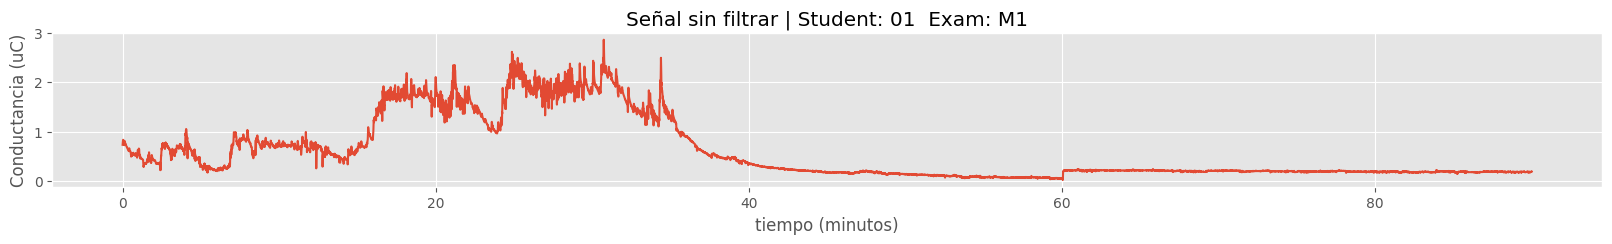

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  01 	Exam:  M2


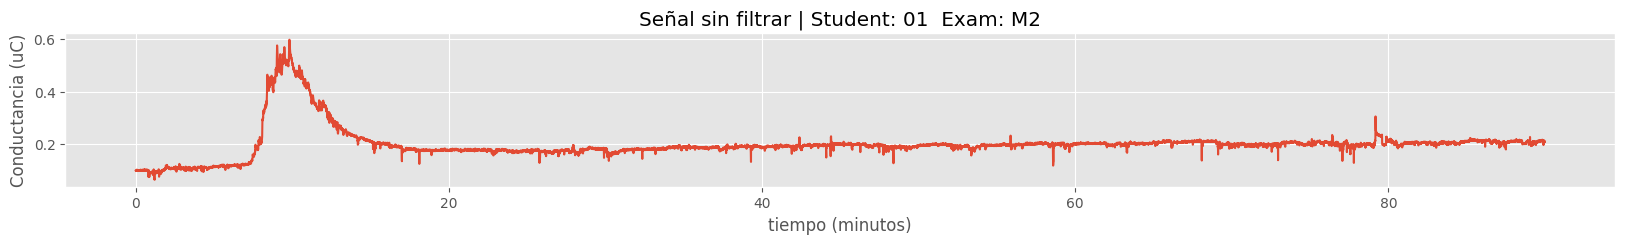

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  01 	Exam:  F1


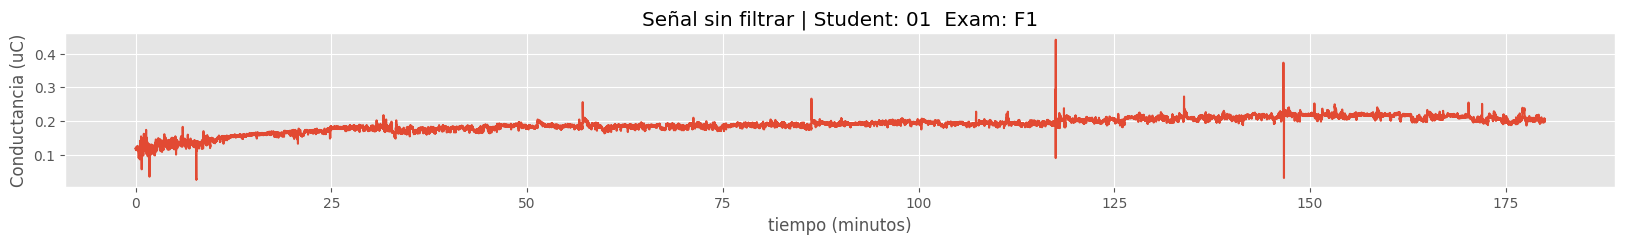

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  02 	Exam:  M1


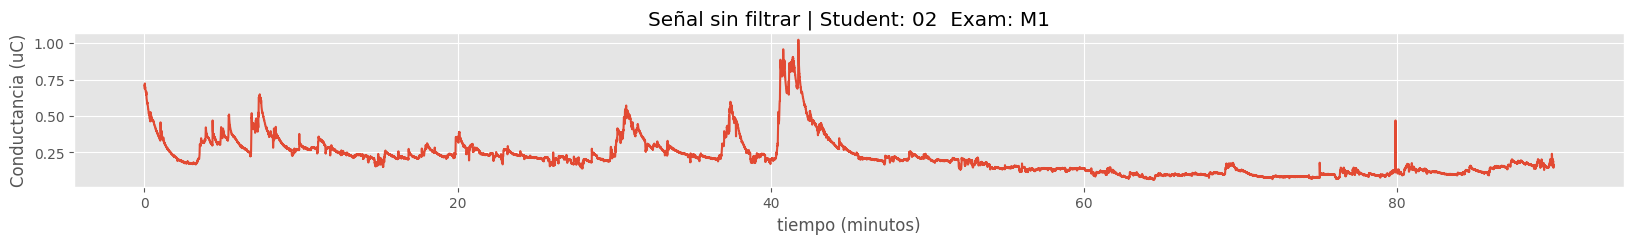

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  02 	Exam:  M2


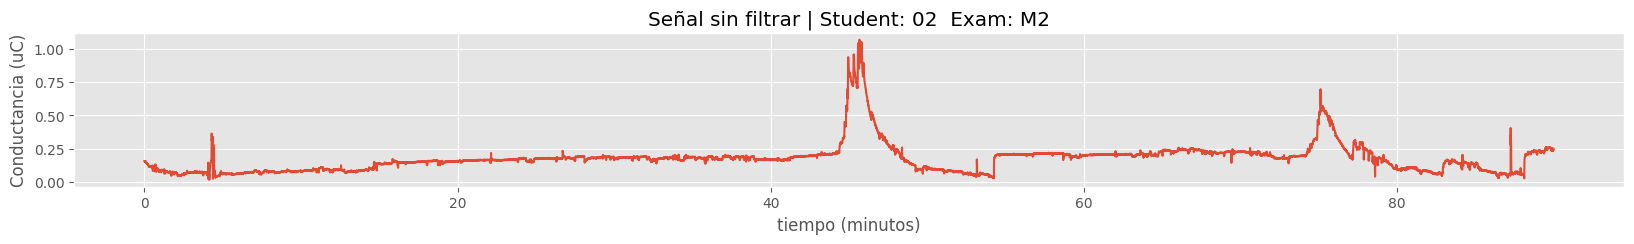

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  02 	Exam:  F1


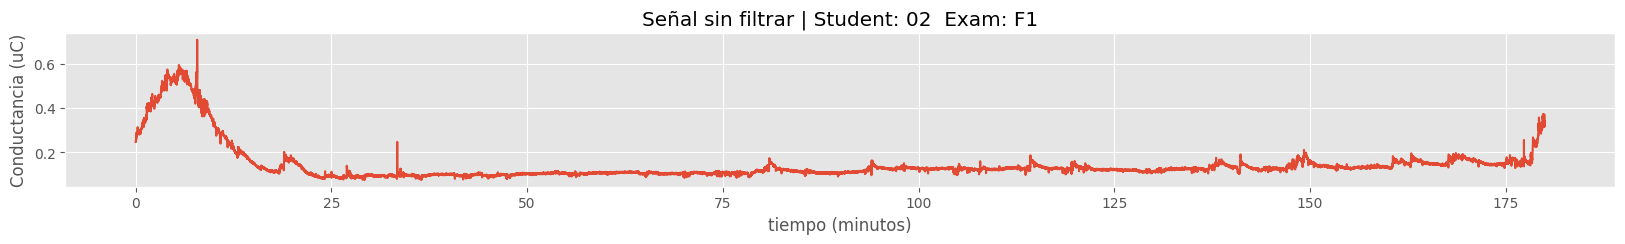

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  03 	Exam:  M1


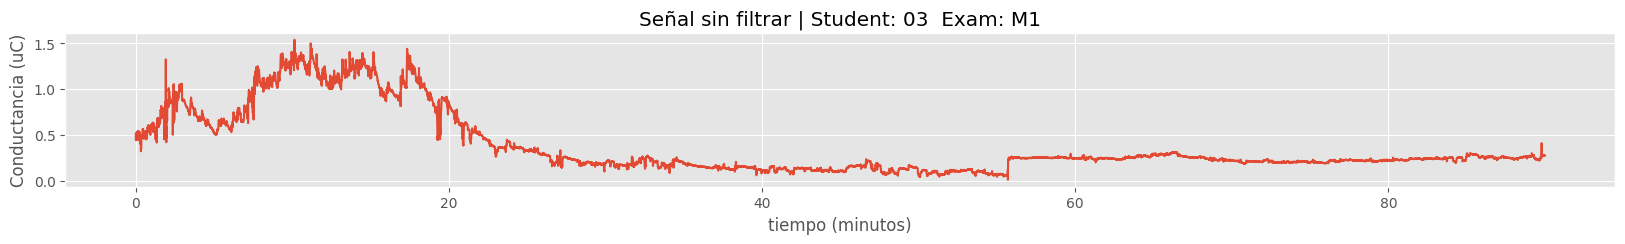

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  03 	Exam:  M2


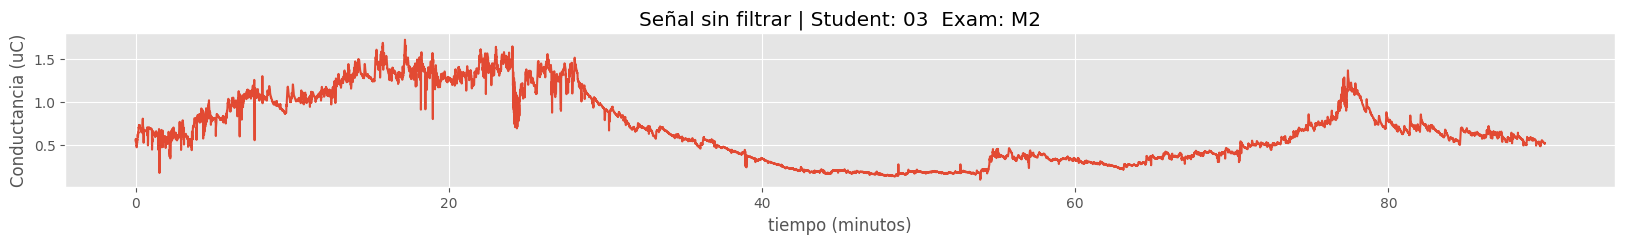

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  03 	Exam:  F1


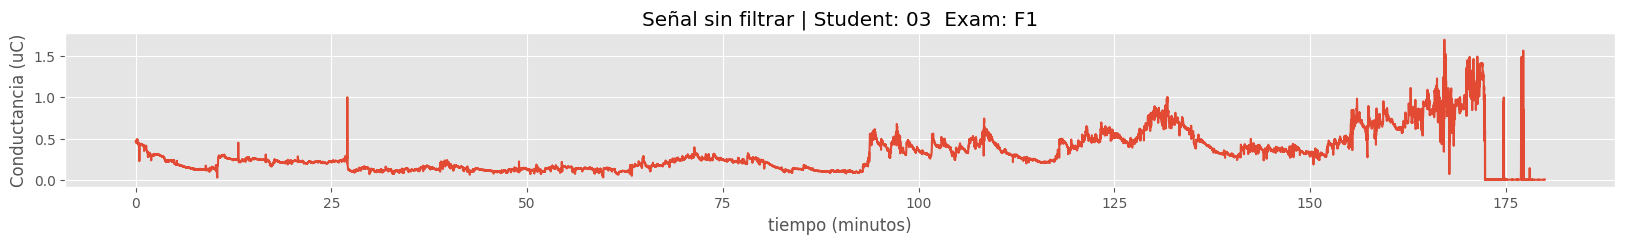

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  04 	Exam:  M1


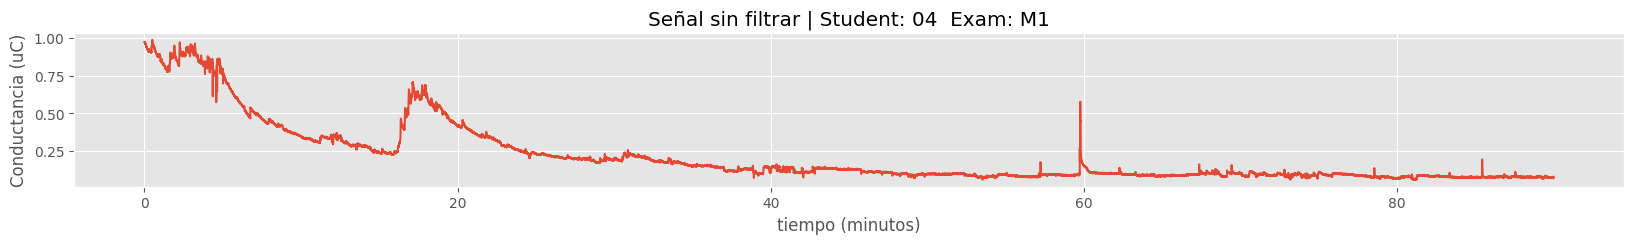

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  04 	Exam:  M2


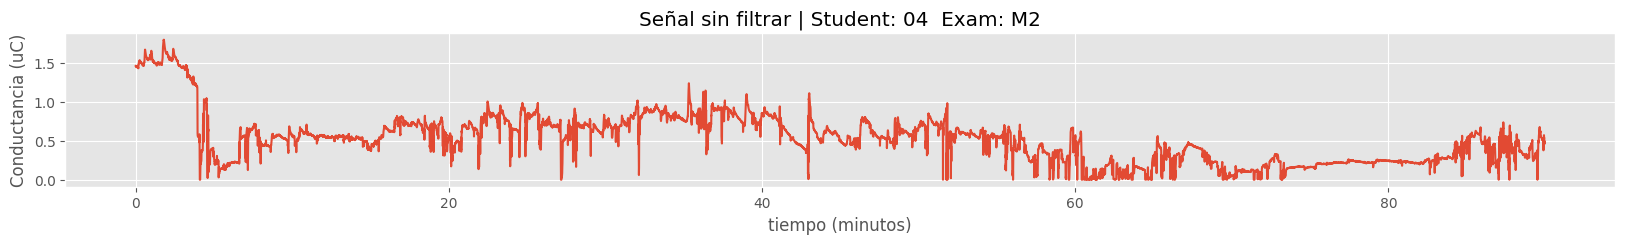

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  04 	Exam:  F1


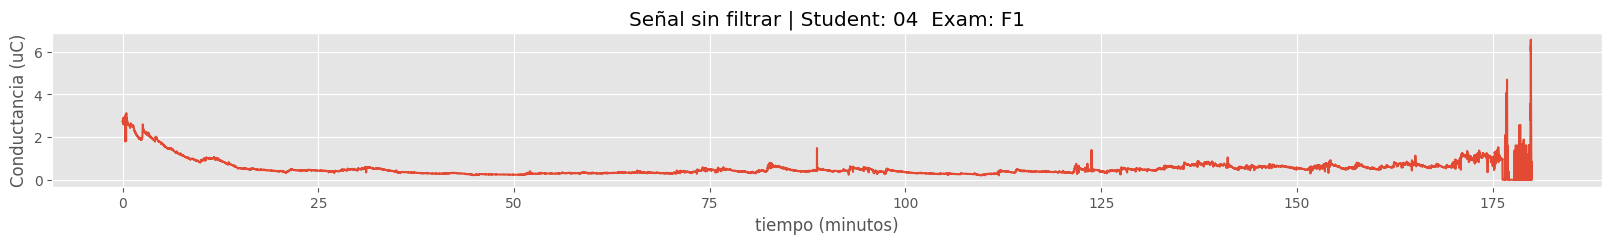

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  05 	Exam:  M1


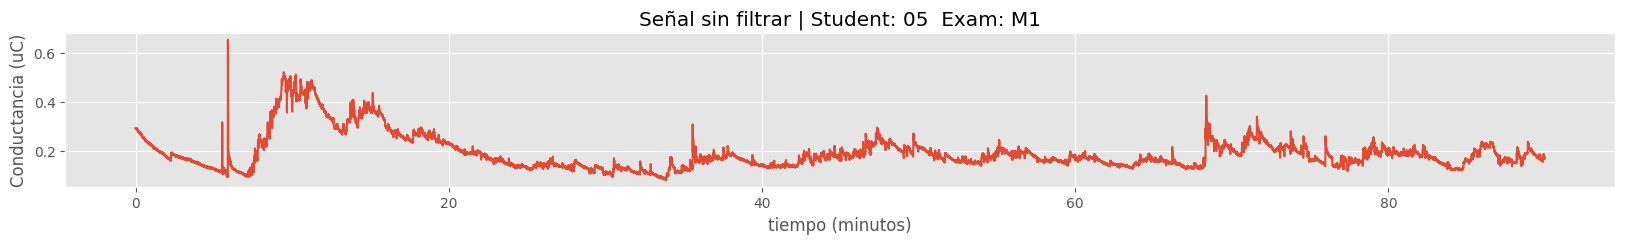

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  05 	Exam:  M2


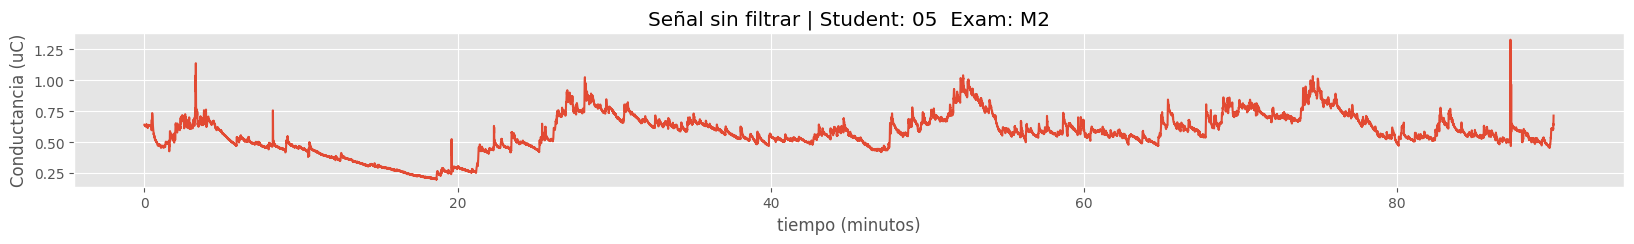

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  05 	Exam:  F1


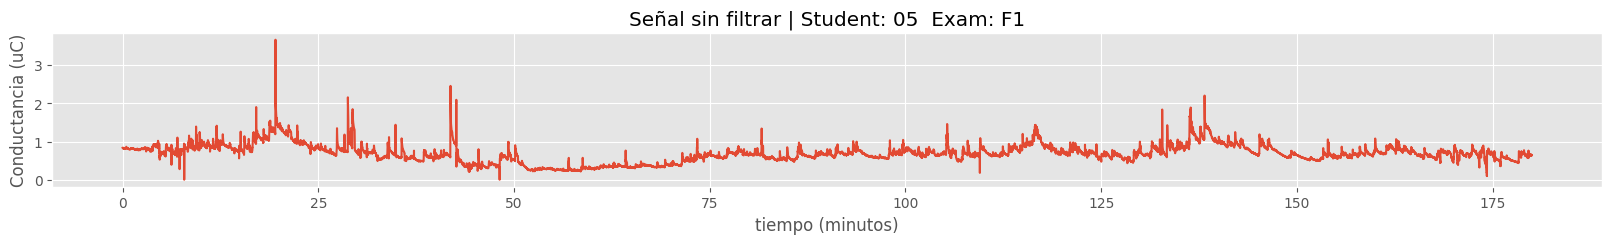

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  06 	Exam:  M1


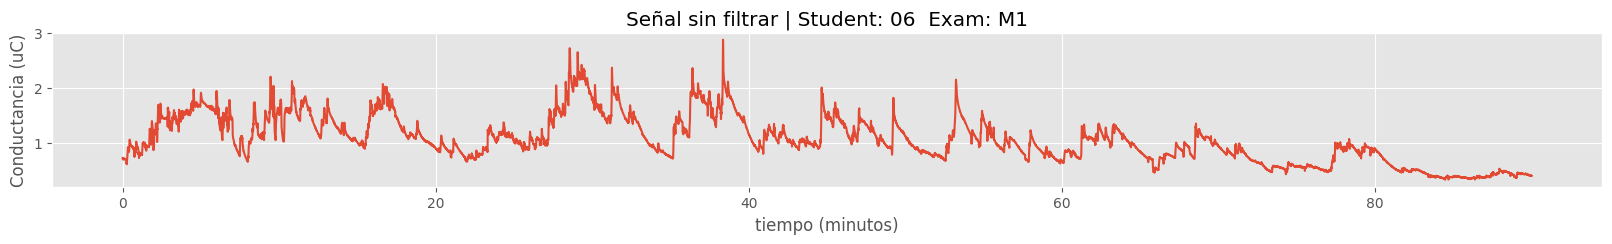

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  06 	Exam:  M2


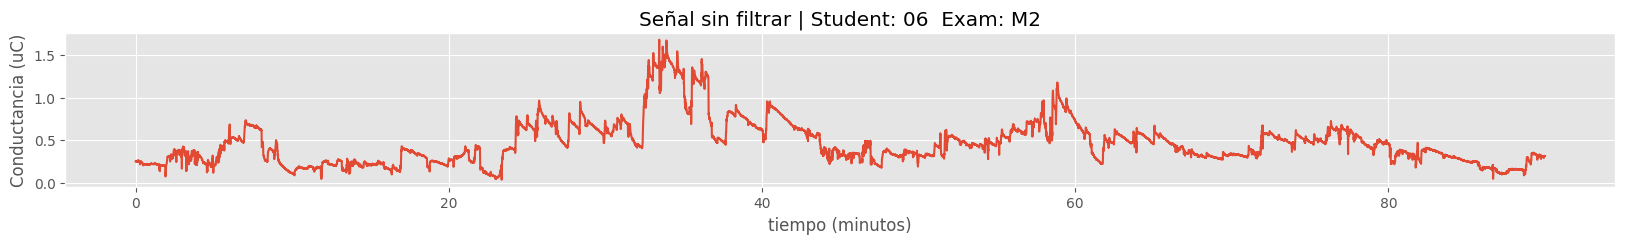

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  06 	Exam:  F1


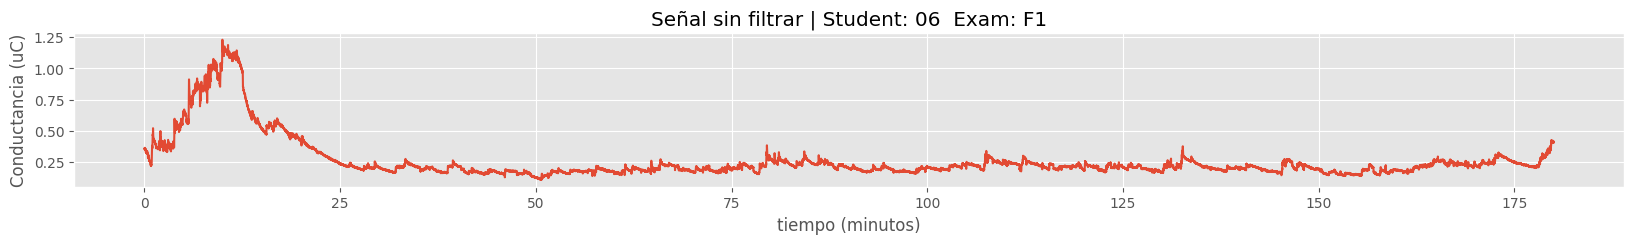

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  07 	Exam:  M1


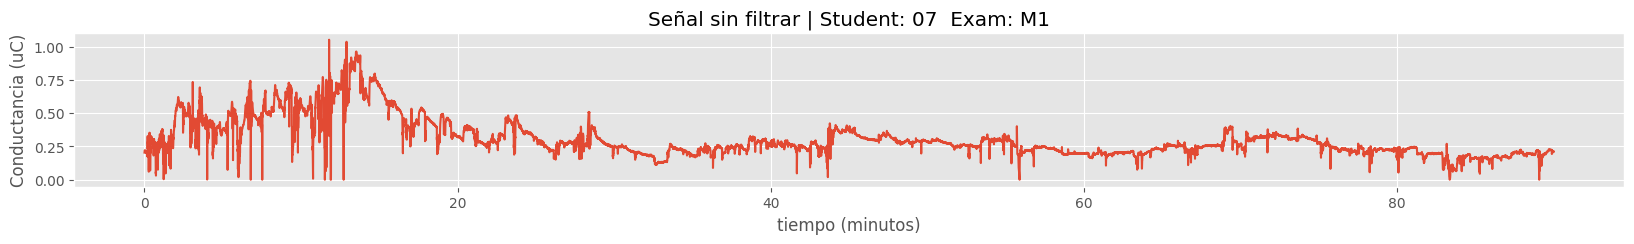

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  07 	Exam:  M2


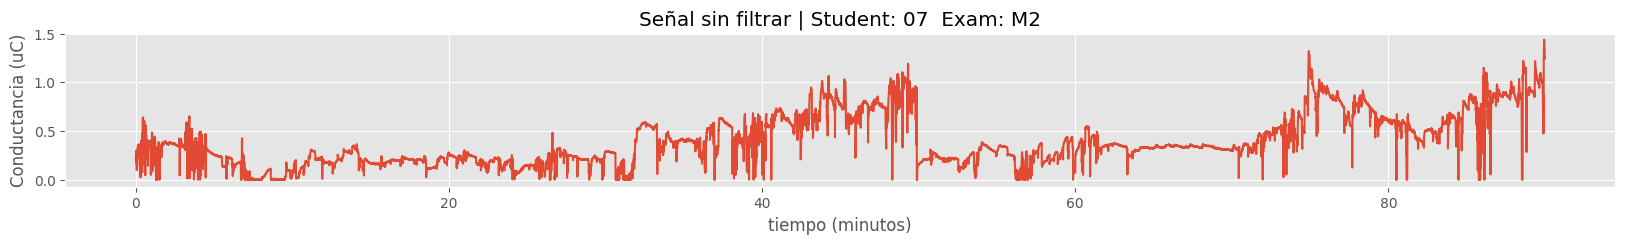

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  07 	Exam:  F1


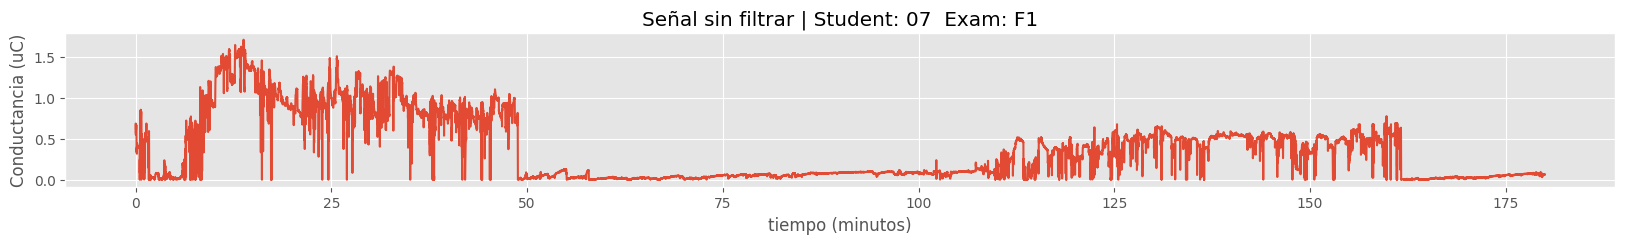

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  08 	Exam:  M1


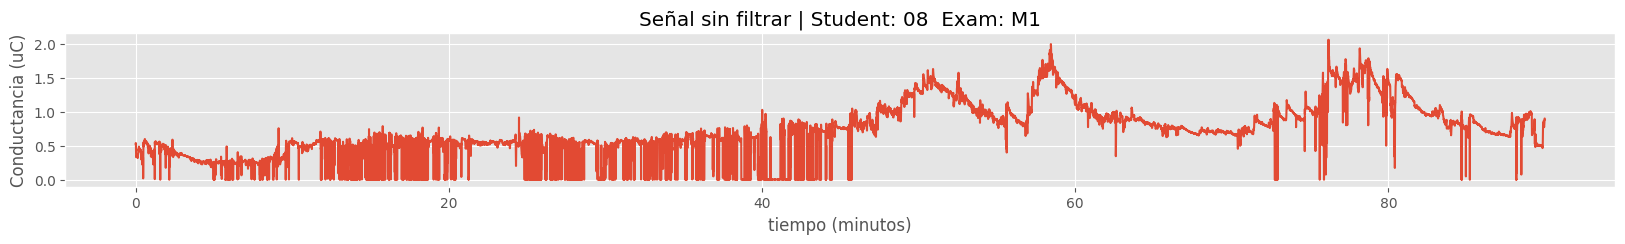

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  08 	Exam:  M2


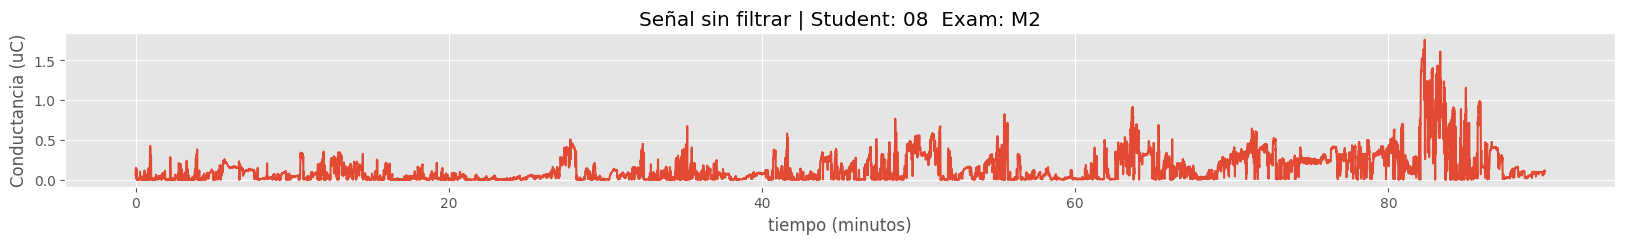

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  08 	Exam:  F1


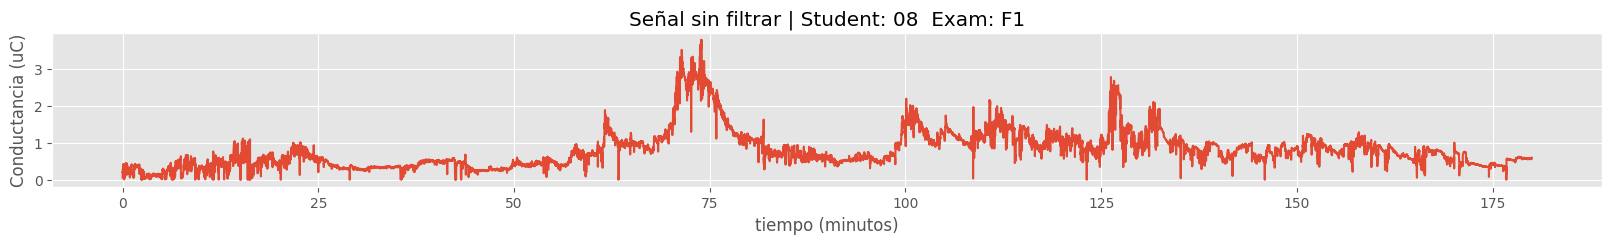

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  09 	Exam:  M1


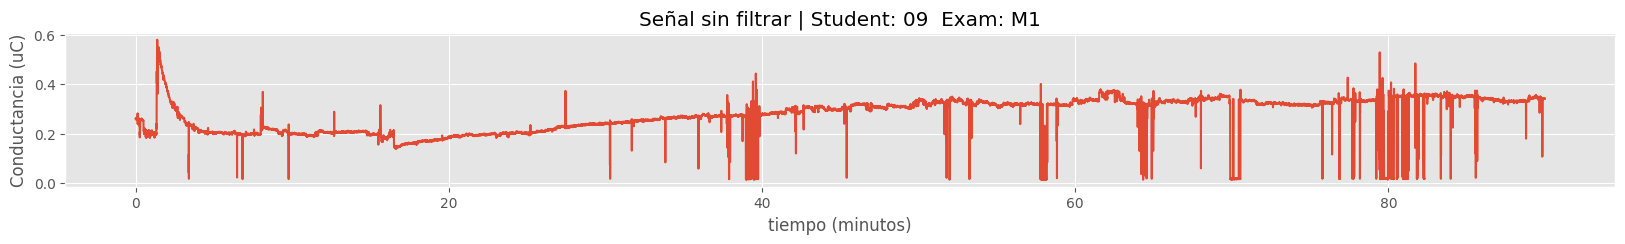

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  09 	Exam:  M2


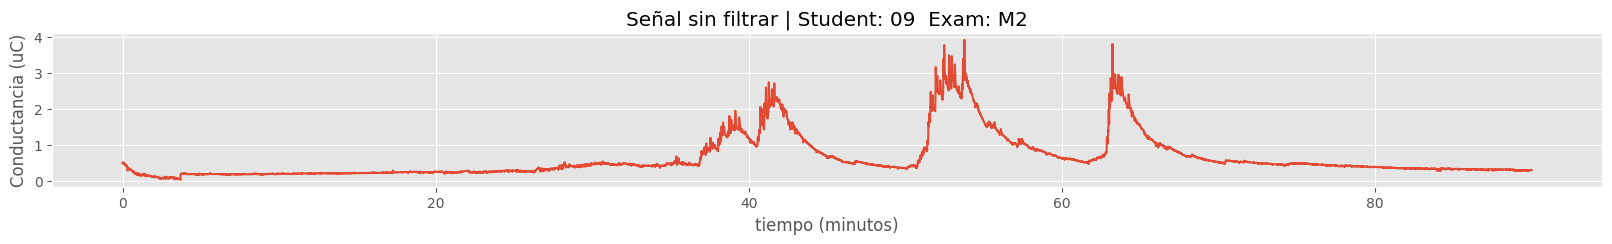

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  09 	Exam:  F1


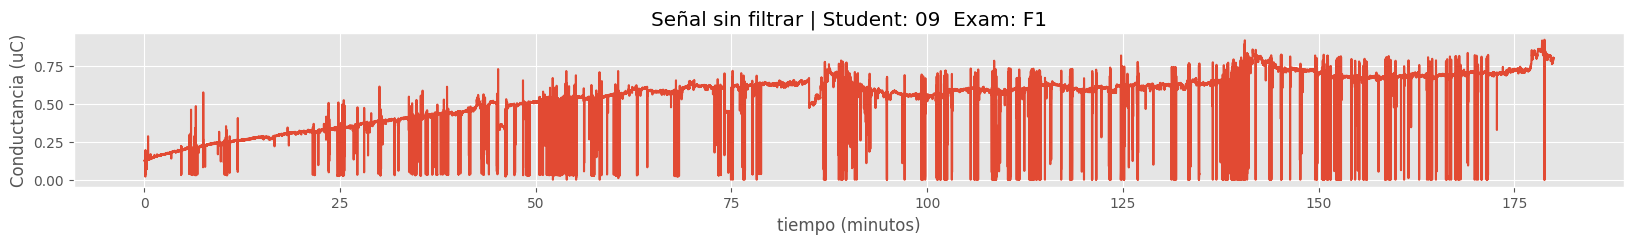

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  10 	Exam:  M1


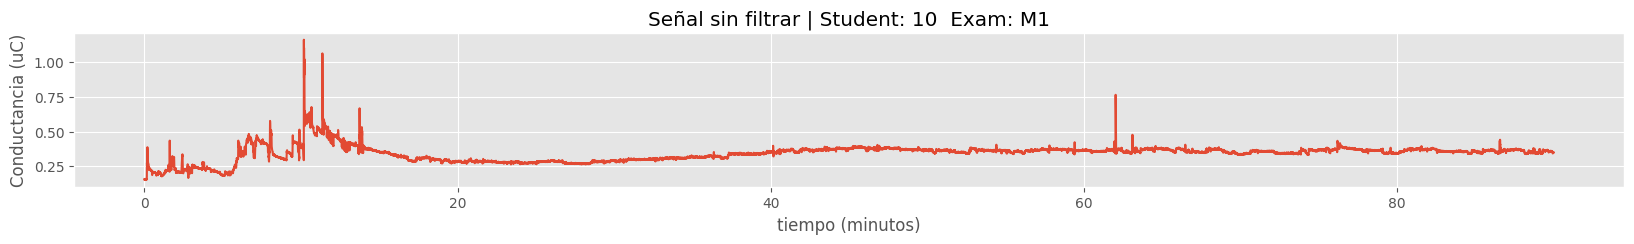

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  10 	Exam:  M2


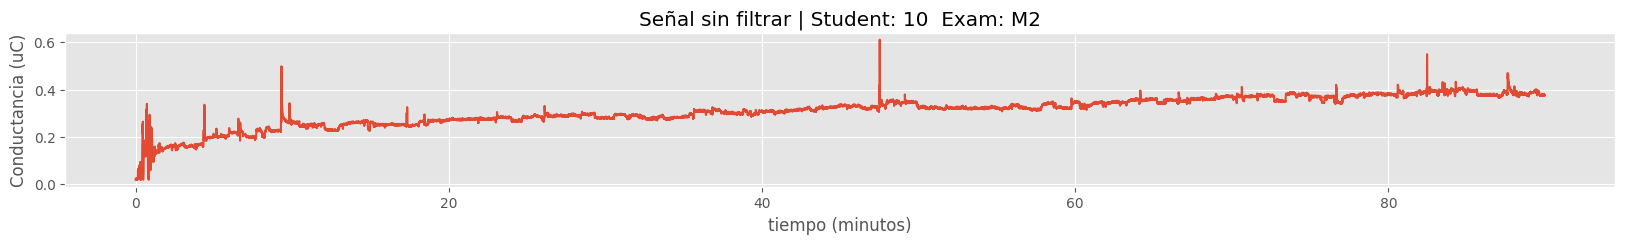

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)



 Student:  10 	Exam:  F1


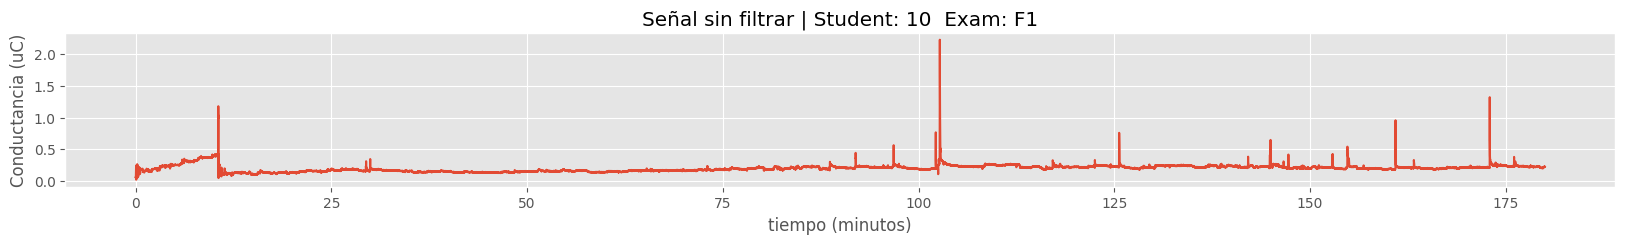

<ipython-input-34-4dc429ba9d5c>:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
<ipython-input-34-4dc429ba9d5c>:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)


In [ ]:
numStu=["01","02","03","04","05","06","07","08","09","10"]
namEx=["M1","M2","F1"]

"""# El array sirve para las pruebas. Determina los límites que se mostrarán en el eje x
show=np.array([[(10000,15000), (10000,15000), (3000,6000)], #01
               [(12000,20000), (6000,15000), (3000,15000)], #02
               [(10000,15000), (3000,9000), (1000,20000)],  #03
               [(10000,22000), (3000,80000), (2000,15000)], #04
               [(10000,20000), (2000,10000), (2000,10000)], #05
               [(12000,20000), (4000,20000), (3000,20000)], #06
               [(11000,20000), (7000,20000), (3000,55000)], #07
               [(12000,20000), (6000,15000), (2000,10000)], #08
               [(10000,20000), (5000,10000), (2000,15000)], #09
               [(10000,20000), (5000,15000), (1000,15000)], #10
               ])"""

# El array contiene una tupla por cada señal (evaluación). 
# La estructura de la tupla es la siguiente: (índice que marca el inicio de la prueba, #samples por cada prueba)
# el numero de samples por cada prueba = tiempo de duración en minutos * 60s * Fs

limitsInf=np.array([[(13500,90*60*4), (10000,90*60*4), (5300,180*60*4)],     #01
            [(17000,90*60*4), (8000,90*60*4), (6000,180*60*4)],              #02
            [(12500,90*60*4), (5000,90*60*4), (9000,180*60*4)],              #03
            [(16000,90*60*4), (12000,90*60*4), (8000,180*60*4)],             #04
            [(13500,90*60*4), (4500,90*60*4), (3500,180*60*4)],              #05
            [(14000,90*60*4), (10000,90*60*4), (6000,180*60*4)],             #06
            [(13600,90*60*4), (10000,90*60*4), (6000,180*60*4)],             #07
            [(14000,90*60*4), (9000,90*60*4), (3600,180*60*4)],              #08
            [(12250,90*60*4), (6500,90*60*4), (6500,180*60*4)],              #09
            [(13700,90*60*4), (8500,90*60*4), (5200,180*60*4)],              #10
            ])

# Cada prueba tiene una frecuencia de corte para el pasabaja específica
fc_ex=np.array([[0.002, 0.002, 0.002],   #01
             [0.002, 0.001, 0.002],   #02
             [0.0002, 0.0002, 0.001], #03
             [0.002, 0.002, 0.002],   #04
             [0.001, 0.001, 0.001],   #05
             [0.002, 0.002, 0.002],   #06
             [0.001, 0.0002, 0.0002], #07
             [0.0002, 0.002, 0.002],  #08
             [0.002, 0.002, 0.002],   #09
             [0.002, 0.002, 0.002]    #10
             ])

grade=np.array([[78, 82, 182],
                [82, 85, 180],
                [77, 90, 188],
                [75, 77, 149],
                [67, 77, 157],
                [71, 64, 175],
                [64, 33, 110],
                [92, 88, 184],
                [80, 39, 126],
                [89, 64, 116]
                ])


Fs=4 # Frecuencia de muestreo del sensor

for i  in range(len(numStu)):
  pathNameInit="EDA/S"
  pathNameSt=pathNameInit+numStu[i]
  
  for j in range(len(namEx)):
    pathName=pathNameSt+namEx[j]+"EDA.csv"
    eda_rawNoLimit= np.genfromtxt(pathName, delimiter="\n")
    eda_rawNoLimit = eda_rawNoLimit[1:,]#Revisamos el array

    print("\n Student: " ,numStu[i], "\tExam: " ,namEx[j])
    """fig, ax = plt.subplots(figsize=(20, 2))
    plt.plot(eda_rawNoLimit)
    plt.title('Señal sin limpiar')
    #plt.xlim(show[i][j][0],show[i][j][1])
    plt.ylim(-0.1,7)
    plt.show()"""

    #-----------------------------DELIMITAMOS LA SEÑAL-----------------------------
    #Delimitamos la señal según la duración de la prueba
    indStart=int(limitsInf[i][j][0]) # El primer término de la data
    indEnd=int(indStart+limitsInf[i][j][1]) # El último índice de la señal
    eda_raw=eda_rawNoLimit[indStart:indEnd]

    #Creamos el vector tiempo asociado
    Ts=1/Fs
    n = np.arange(0,eda_raw.shape[0])  # t = n*Ts
    t = n*Ts

    # Ploteamos la señal delimitada
    fig, ax = plt.subplots(figsize=(20, 2))
    plt.plot(t/60, eda_raw)
    plt.title('Señal sin filtrar | '+"Student: "+numStu[i]+"  Exam: "+namEx[j])
    plt.xlabel('tiempo (minutos)')
    plt.ylabel('Conductancia (uC)')
    plt.show()

    #-----------------------------CALCULAMOS EL LABEL ASOCIADO A CADA SEÑAL-----------------------------
    """Cuando el estudiate obtuvo una nota mayor o igual al 80% del puntaje total para la prueba evaluada 
    le corresponderá una etiqueta de 1, caso contrario esta será 0"""

    prueba=namEx[j]
    if prueba == "M1" or prueba == "M2":
      if grade[i][j]>=0.8*100:
        label= int(True)
      else:
        label= int(False)
      
    elif prueba == "F1":
      if grade[i][j]>=0.8*200:
        label= int(True)
      else:
        label= int(False)


    #-----------------------------EXTRAEMOS LOS FEATURES-----------------------------
    fc=fc_ex[i][j] #Asignamos la frecuencia de corte correspondiente de acuerdo al estudio revisado
    tw5_dic,tw15_dic,tw30_dic = features_EDA(eda_raw, fc, Fs,t)
    
    #Añadimos la etiqueta como elemento a los diccionarios
    tw5_dic[column_names[-1]], tw15_dic[column_names[-1]], tw30_dic[column_names[-1]] = label,label,label


    #-----------------------------IDENTIFICACIÓN DE ESTUDIANTE Y PRUEBA-----------------------------
    tw5_row={column_names[0]:int(numStu[i]),column_names[1]:namEx[j]}
    tw5_row.update(tw5_dic) #Añadimos estos items a los diccionarios de las características
    
    #Repetimos para los diccionarios de tw15 y tw30
    tw15_row={column_names[0]:int(numStu[i]),column_names[1]:namEx[j]}
    tw15_row.update(tw15_dic)

    tw30_row={column_names[0]:int(numStu[i]),column_names[1]:namEx[j]}
    tw30_row.update(tw30_dic)


    #-----------------------------AGREGAMOS A LA DATA GENERADA A CADA DATAFRAME-----------------------------
    Tw5_data=Tw5_data.append(tw5_row, ignore_index=True)
    Tw15_data=Tw15_data.append(tw15_row, ignore_index=True)
    Tw30_data=Tw30_data.append(tw30_row, ignore_index=True)

## Mostramos los *Dataframes*

In [ ]:
print(Tw30_data.dtypes)
Tw5_data['More80'] = Tw5_data['More80'].astype('category')# Convertimos la última columna al tipo categórico.
print("\n",Tw5_data.dtypes)

#Repetimos lo mismo para los 2 dataframes restantes
Tw15_data['More80'] = Tw15_data['More80'].astype('category')
Tw30_data['More80'] = Tw30_data['More80'].astype('category')

Student        object
Exam           object
mu_Start      float64
mu_Middle     float64
mu_End        float64
var_Start     float64
var_Middle    float64
var_End       float64
ratio         float64
mu_diff       float64
var_diff      float64
More80          int64
dtype: object

 Student         object
Exam            object
mu_Start       float64
mu_Middle      float64
mu_End         float64
var_Start      float64
var_Middle     float64
var_End        float64
ratio          float64
mu_diff        float64
var_diff       float64
More80        category
dtype: object


#Clasificando con RandomForest con envetanamiento de 5 minutos(Tw5)

In [ ]:
#Drop dos primeras columnas:
Tw5_data = Tw5_data.drop(columns=['Student' , 'Exam'])
display(Tw5_data)

In [ ]:
X = Tw5_data.iloc[:, 0:-1].values
y = Tw5_data.iloc[:,-1].values

In [ ]:
#Visualizacion
import pandas as pd
display(pd.DataFrame(X), pd.DataFrame(y))

##Optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

In [ ]:
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [ ]:
scores = grid_search.cv_results_['mean_test_score']
# extract the mean score and variance
mean_score = np.mean(scores)
variance = np.var(scores)

# print the results
print('All scores:', scores)
print('Mean score:', mean_score)
print('Variance:', variance)


All scores: [1.         1.         1.         1.         1.         1.
 0.95       0.95       0.95       0.98333333 1.         1.
 0.98333333 0.98333333 1.         0.9        0.91666667 0.93333333
 0.91666667 0.9        0.9        0.91666667 0.9        0.9
 0.88333333 0.88333333 0.85       1.         1.         1.
 0.98333333 1.         1.         0.95       0.95       0.95
 0.98333333 1.         1.         0.98333333 0.98333333 1.
 0.9        0.91666667 0.93333333 0.91666667 0.9        0.9
 0.91666667 0.9        0.9        0.88333333 0.88333333 0.85
 1.         1.         1.         1.         1.         1.
 0.95       0.95       0.95       0.98333333 1.         1.
 0.98333333 0.98333333 1.         0.9        0.91666667 0.93333333
 0.91666667 0.9        0.9        0.91666667 0.9        0.9
 0.88333333 0.88333333 0.85      ]
Mean score: 0.9479423868312757
Variance: 0.0022317058713949432


El GridSearch encontró valores de accuracy altos, pero el best model probablemente está overfit, por eso cogeremos los best parameters y haremos cross-validation de nuevo.

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_params

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
rf2 = RandomForestClassifier(max_depth= None,
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 100,random_state=42)

In [ ]:
scores = cross_val_score(rf2,X, y, cv=5)
scores

array([1., 1., 1., 1., 1.])

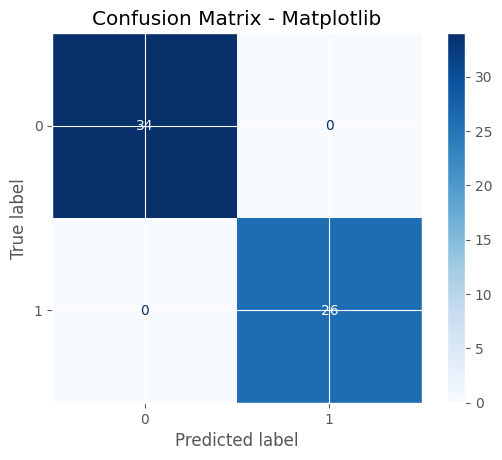

In [ ]:
#Metricas 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

# Matplotlib confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Matplotlib')
plt.show()

In [ ]:
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

1.0


A pesar de correr cross-validation múltiples veces, el modelo alcanza 1 de accuracy consistentemente, probablemente el overfit es por la alta complejidad del modelo en relación a la poca cantidad de data que tenemos, tendríamos que simplificar el modelo.

#Clasificando con RandomForest con envetanamiento de 15 minutos(Tw15)


In [ ]:
#Drop dos primeras columnas:
Tw15_data = Tw15_data.drop(columns=[ 'Student' , 'Exam'])
display(Tw15_data)

In [ ]:
X = Tw15_data.iloc[:, 0:-1].values
y = Tw15_data.iloc[:,-1].values

##Optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

In [ ]:
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [ ]:
scores = grid_search.cv_results_['mean_test_score']
# extract the mean score and variance
mean_score = np.mean(scores)
variance = np.var(scores)

# print the results
print('All scores:', scores)
print('Mean score:', mean_score)
print('Variance:', variance)

All scores: [1.         1.         1.         0.98333333 1.         1.
 0.81666667 0.85       0.85       0.98333333 1.         1.
 0.96666667 0.98333333 0.96666667 0.83333333 0.81666667 0.83333333
 0.81666667 0.83333333 0.8        0.81666667 0.83333333 0.8
 0.78333333 0.8        0.8        1.         1.         1.
 0.98333333 1.         1.         0.81666667 0.85       0.85
 0.98333333 1.         1.         0.96666667 0.96666667 0.96666667
 0.83333333 0.81666667 0.83333333 0.81666667 0.83333333 0.8
 0.81666667 0.83333333 0.8        0.78333333 0.8        0.8
 1.         1.         1.         0.98333333 1.         1.
 0.81666667 0.85       0.85       0.98333333 1.         1.
 0.96666667 0.98333333 0.96666667 0.83333333 0.81666667 0.83333333
 0.81666667 0.83333333 0.8        0.81666667 0.83333333 0.8
 0.78333333 0.8        0.8       ]
Mean score: 0.8948559670781893
Variance: 0.007494115056986563


El GridSearch encontró valores de accuracy altos, pero el best model probablemente está overfit, por eso cogeremos los best parameters y haremos cross-validation de nuevo.

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_params

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
rf2 = RandomForestClassifier(max_depth= None,
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 100,random_state=42)

In [ ]:
scores = cross_val_score(rf2,X, y, cv=5)
scores

array([1., 1., 1., 1., 1.])

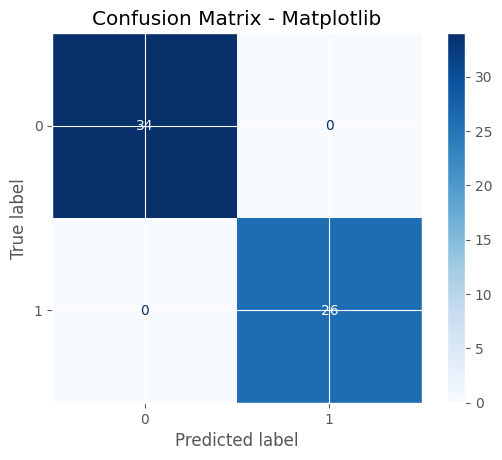

In [ ]:
#Metricas 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

# Matplotlib confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Matplotlib')
plt.show()

In [ ]:
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

1.0


A pesar de correr cross-validation múltiples veces, el modelo alcanza 1 de accuracy consistentemente, probablemente el overfit es por la alta complejidad del modelo en relación a la poca cantidad de data que tenemos, tendríamos que simplificar el modelo.

#Clasificando con RandomForest con envetanamiento de 30 minutos(Tw30)

In [ ]:
#Drop dos primeras columnas:
Tw30_data = Tw30_data.drop(columns=[ 'Student' , 'Exam'])
display(Tw30_data)

In [ ]:
X = Tw30_data.iloc[:, 0:-1].values
y = Tw30_data.iloc[:,-1].values

##Optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

In [ ]:
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [ ]:
scores = grid_search.cv_results_['mean_test_score']
# extract the mean score and variance
mean_score = np.mean(scores)
variance = np.var(scores)

# print the results
print('All scores:', scores)
print('Mean score:', mean_score)
print('Variance:', variance)

All scores: [1.         1.         1.         1.         1.         0.98333333
 0.9        0.9        0.88333333 0.98333333 0.98333333 0.98333333
 0.95       0.98333333 0.98333333 0.83333333 0.81666667 0.83333333
 0.81666667 0.81666667 0.83333333 0.81666667 0.81666667 0.83333333
 0.83333333 0.81666667 0.83333333 1.         1.         1.
 0.98333333 0.98333333 0.98333333 0.9        0.9        0.88333333
 0.96666667 0.98333333 0.98333333 0.93333333 0.96666667 0.98333333
 0.83333333 0.81666667 0.83333333 0.81666667 0.81666667 0.83333333
 0.81666667 0.81666667 0.83333333 0.83333333 0.81666667 0.83333333
 1.         1.         1.         1.         1.         0.98333333
 0.9        0.9        0.88333333 0.98333333 0.98333333 0.98333333
 0.95       0.98333333 0.98333333 0.83333333 0.81666667 0.83333333
 0.81666667 0.81666667 0.83333333 0.81666667 0.81666667 0.83333333
 0.83333333 0.81666667 0.83333333]
Mean score: 0.903909465020576
Variance: 0.005859201679960704


El GridSearch encontró valores de accuracy altos, pero el best model probablemente está overfit, por eso cogeremos los best parameters y haremos cross-validation de nuevo.

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
rf2 = RandomForestClassifier(max_depth= None,
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 100,random_state=42)

In [ ]:
scores = cross_val_score(rf2,X, y, cv=5)
scores

array([1., 1., 1., 1., 1.])

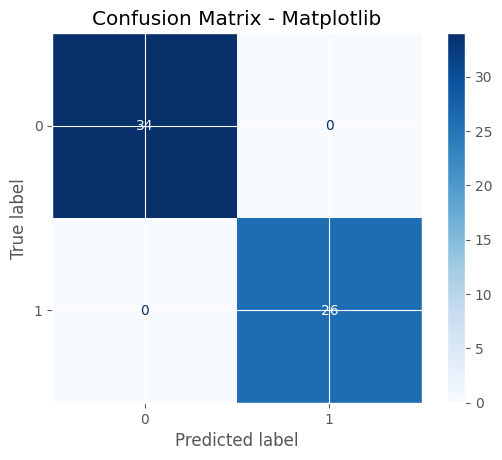

In [ ]:
#Metricas 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = best_model.predict(X)
cm = confusion_matrix(y, y_pred)

# Matplotlib confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Matplotlib')
plt.show()

In [ ]:
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

1.0


A pesar de correr cross-validation múltiples veces, el modelo alcanza 1 de accuracy consistentemente, probablemente el overfit es por la alta complejidad del modelo en relación a la poca cantidad de data que tenemos, tendríamos que simplificar el modelo.